In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def matprint(mat, fmt="g"):
    """
    Pour une un print plus clair de la matrice
    https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Table of contents
* [Algorithme non distribué 2 taches 2 classes](#Algorithme-non-distribué-2-taches-2-classes)
     * [1ère étape: Calcul des moyennes empiriques](#1ère-étape)
     * [2ème étape: Estimation de $c$ et de $\mathcal{M}$](#2ème-étape)
     * [3ème étape: Calcul des labels optimaux](#3ème-étape)
     * [4ème étape: Estimation des $m_{tj}$](#4ème-étape)
     * [5ème étape: Calcul de $V$](#5ème-étape)
     * [6ème étape: Evaluation et calcul d'erreur](#6ème-étape)
* [2-class Gaussian mixture transfer](#2-class-Gaussian-mixture-transfer-(c.f.-Figure-2))
* [Adding Tasks](#Adding-tasks)
* [Algorithme distribué 2-tâches 2-classes](#Algorithme-distribué-2-tâches-2-classes)
     * [Serveur isolé](#Serveur-isolé)
* [Distributively adding tasks](#Distributively-adding-tasks)
     * [Working with real data](#Real-Data)
* [Algorithme distribué k-tâches 2-classes](#Algorithme-distribué-k-tâches-m-classes)
     

Créons des données synthétiques gaussiennes. Ici nous nous intéresserons dans un premier temps au cas où $m=2$. (Binary MTL Supervised Principal Component Analysis) 

# Algorithme non distribué 2 taches 2 classes
Fonctions pour générer des données synthétiques gaussiennes

In [3]:
def mean_random_matrix(m, k, p, l, h, random_seed=42):
    """
    Retourne une matrice M de taille pxm*k contenant
    les moyennes de chaque composante de chaque vecteur aléatoire
    pour l'instant les moyennes sont tirées aléatoirement 
    suivant la loi uniforme sur l, h (pas convaincu par ce choix)
    m est le nombre de classes
    k est le nombre de taches
    p est le nombre de features
    """
    np.random.seed(random_seed)
    M = []
    tmp = []
    for task in range(k):
        tmp = []
        for classe in range(m):
            # on crée un vecteur de moyennes égales pour chaque classes
            # de sorte à créer des classes gravitant autour d'une meme moyenne
            tmp.append(np.ones((p,1))*np.random.uniform(low = 0.0, high = h))
        M.append(tmp)
    return M

In [4]:
def mean_matrix(p, beta=None, k=2, m=2, random_seed=42, random=False):
    """
    Crée des vecteurs de moyennes en respectant les conditions de non trivialité 
    retourne un tableau contenant k tableaux de m moyennes.
    beta est le paramètre de task relatedness. Si beta n'est pas précisé, il est tiré au hasard uniformément sur [0,1] pour chaque t.
    k=2, m=2 par défaut
    """
    np.random.seed(random_seed)
    mu = np.zeros((p,1))
    mu[0]= 1
    mu_ortho = np.zeros((p,1))
    mu_ortho[-1] = 1
    
    M = []
    classes = []
    for l in range(m):
        classes.append((-1)**l*mu)
    M.append(classes)
    
    for t in range(1, k):
        if random:
            print("random")
            beta = np.random.uniform(0, 1)
        print("beta", beta)
        mu_t = beta*mu+np.sqrt(1-beta**2)*mu_ortho
        classes = []
        for l in range(m):
            classes.append((-1)**l*mu_t)
        M.append(classes)
    return M

In [5]:
def gaussian_synthetic_data(n, p, m, t, n_t, M, random_seed=42):
    """
    Renvoie un tableau de données synthétiques gaussiennes. X[0] accède aux données de la premiere tache.
    X[0][1] accede aux données de la deuxieme classe de la premiere tache.
    (vecteurs gaussiens de taille n_j * p tq sum(n_j for j) = n)
    à partir du nombre d'échantillons n de taille p et du nombre de classe m.
    t est le nombre de tâches
    n_t est un vecteur comprenant les différentes valeurs n_j pour chaque task
    M est la matrice des moyennes de chaque composante 
    de chaque vecteur aléatoire
    """
    # assert(sum(n_j)/n==1
    
    np.random.seed(random_seed)
    X = []
    tmp = []
    y_test = []
    for task in range(t):
        # pour une tache on a m classes
        tmp = []
        for k in range(m):
            X_k = np.empty((n_t[task][k], p))
            # on prendra la transposée a la fin
#             print( n_t[task][k])
            for j in range(n_t[task][k]):
                # on crée n_j[task][k] vecteurs aléatoires de taille 1xp
                # std = 1?
                # comment utiliser des vecteurs de moyennes pour générer les données ?
                mean = np.reshape(M[task][k], p)
                X_k[j] = np.random.multivariate_normal(mean, np.identity(p))
                y_test.append(k)
            X_k = np.transpose(X_k)
            #print(k)
            tmp.append(X_k)
            # print("tmp = ", tmp)
        X.append(tmp)
            
    return X, y_test

In [6]:
def normalisation(X, p):
    for i in range(len(X)):
        for j in range(len(X[i])):
            X[i][j] *= 1/np.sqrt(p)
    
    return X

## 1ère étape
Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

In [7]:
def empirical_mean(nb_tasks, nb_classes, X, p, n_t, display=False):
    """
    Retourne la matrice M avec les produits scalaires croisés
    cf. Remark 1
    """
    
    M = np.empty((nb_tasks*nb_classes, nb_tasks*nb_classes)) # ici 4x4
    for i in range(nb_tasks):
        for j in range(nb_classes):
            for k in range(nb_tasks):
                for l in range(nb_classes):
                    if i == k and j == l:
                        moitie = int(n_t[i][j]/2)
#                         print("DEBUG diagonal")
#                         print(f"i = {i}, j = {j}")
#                         print(i*nb_classes+j, i*nb_classes+j)
#                         print("moitie : ", moitie)
                        
                        M[i*nb_classes+j][i*nb_classes+j] = np.ones((moitie, 1)).T@X[i][j].T[:moitie]@X[i][j].T[moitie:].T@np.ones((moitie))
                        M[i*nb_classes+j][i*nb_classes+j] /= moitie**2
                    else:
#                         print(i*nb_classes+j, k*nb_classes+l)
#                         print(i, j, k, l)
                        M[i*nb_classes+j][k*nb_classes+l] = np.ones((n_t[i][j], 1)).T@X[i][j].T@X[k][l]@np.ones((n_t[k][l]))
                        M[i*nb_classes+j][k*nb_classes+l] /= n_t[i][j]*n_t[k][l]
    
    if display:
        for t in range(nb_tasks):
            for l in range(nb_classes):
                print(f"class {t*nb_classes+l} empirical mean = {np.mean(M[t*nb_classes+l])}")
                
    return M

In [8]:
def true_mean(M, p, nb_tasks, nb_classes):
    """
    Retourne un ndarray contenant les vraies moyennes avec lequel on peut travailler
    """
    true_M = np.empty((nb_tasks*nb_classes, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            mean = np.reshape(M[t][l], (p,))
            true_M[t*nb_classes+l] = mean

    return np.transpose(true_M)

In [9]:
# utile pour les puissances négatives
def power_diagonal_matrix(D, exponent):
    diag = np.zeros(len(D))
    for i in range(len(D)):
        diag[i] = D[i][i]**exponent
    
    return np.diag(diag)

## 2ème étape
Estimer $c$ et $\mathcal{M}\in\mathbb{R}^{2k\times 2k}$. 
$c=\left[ c_{11},\ldots,c_{km} \right]^T\in\mathbb{R}^{km}$

In [10]:
def estimate_c(n_t, n, nb_tasks, nb_classes):
    """
    Estime le vecteur c en divisant n_t[nb_tasks][nb_classes]/n
    """
    c = np.empty(nb_tasks*nb_classes)
    for task in range(nb_tasks):
        for m in range(nb_classes):
            c[task*nb_classes+m]=n_t[task][m]/n
            
    return c

In [11]:
def compute_M_cal(n,p,Dc,MM, k=2, display=False):
    """
    renvoie la matrice M cursive estimée.
    O(2*k)
    """
    c0 = k*p/n
    correlation_matrix = 1/c0*np.power(Dc, 1/2)@MM@np.power(Dc, 1/2)
    if display==True:
        plt.imshow(correlation_matrix)
        plt.show()
    return correlation_matrix

## 3ème étape
Let's compute optimal labels

In [12]:
# a revoir ?

def label_evaluation(nb_tasks, nb_classes, Dc, M_estimated, c0, task_target=None):
    """
    Evalue le label y pour une tache t pour 2 classes
    task_target=None par défaut, permet de choisir la tâche target en cas d'algo distribué.
    """
    inverse = np.linalg.inv(M_estimated+np.identity(nb_classes*nb_tasks))
    # 0(16*k^3)
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # O(2*k)
    y = np.zeros((nb_tasks*nb_classes, 1))
    e3_e4 = np.zeros((nb_tasks*nb_classes,1))
    if task_target is not None:
        e3_e4[2*task_target] = 1
        e3_e4[2*task_target+1] = -1
    else:
        e3_e4[-2] = 1
        e3_e4[-1] = -1
    tilde_y=np.linalg.solve((Dc+Dc@M_estimated@Dc*1/c0),(Dc*1/c0@M_estimated@(e3_e4)))
    # O(8*k^3)
    return tilde_y
#malik's formula:
#tilde_y=(diag(c)*MM*diag(c)/co+diag(c))\((e3-e4)'*MM*diag(c))';

## 4ème étape
Estimation des $m_{tj}$, étant les $k\times m$ moyennes estimées pour modéliser nos données.

In [13]:
def asymptotic_mean(nb_tasks, nb_classes, y_tilde, Dc, correlation_matrix, t, j):
    """
    compute asymptotic mean m_tj
    t current task
    j current class
    """
    y_transpose = np.transpose(y_tilde)
    etj = np.zeros((nb_tasks*nb_classes, 1))
    etj[t*nb_classes+j] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # Dc^1/2 ou Dc^{-1/2} ?
    m_tj = y_transpose.dot(np.power(Dc, 1/2)).dot(correlation_matrix).dot(power_dc).dot(etj)
    m_tj /= np.sqrt(y_transpose.dot(np.power(Dc, 1/2).dot(correlation_matrix).dot(np.power(Dc, 1/2)) + Dc).dot(y_tilde))
    return m_tj[0][0]

## 5ème étape
Calcul de $V$ le sous-espace engendrés par les $\tau$ plus grands vecteurs propres. Dans le cas du binary MTL-SPCA, $V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}\in\mathbb{R}^{p\times1}$, avec $J\in\mathbb{R}^{n\times km}$

In [14]:
def aggregate_array(X, p, n, nb_tasks, nb_classes):
    X_aggregated = np.empty((p, n))
    class_1 = X[0][0]
    for t in range(nb_tasks):
        for l in range(nb_classes):
            if t==0 and l==0:
                continue
            class_1 = np.append(class_1, X[t][l], 1)
    X_aggregated = class_1
    return X_aggregated

$V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}$

In [15]:
def create_J(nb_classes, nb_tasks, n, n_t):
    # enlever paramètre n
    left = 0
    beg = 0
    for i in range(nb_tasks):
        left += int(sum(n_t[i]))
    J = np.zeros((left, nb_tasks*nb_classes))
    #matprint(J)
    for t in range(nb_tasks):
        for j in range(nb_classes):
            for i in range(beg, beg+n_t[t][j]):
                J[i][t*nb_classes+j] = 1
            beg += n_t[t][j]
    return J

In [16]:
def compute_V_old(y_tilde, X, J):
    """
    Utilise la formule explicite de V pour la classification binaire
    """
    xy_product = X.dot(J).dot(y_tilde)
    return xy_product/np.linalg.norm(xy_product)

def compute_V(y, X, J, n):
    """
    Recalcule V (calcul vecteur propre)
    Vstar dans le fichier matlab
    Division par p, si les X pas normalisé ?
    wtf is wrong with V? 
    """
    #X*J*(tilde_y*tilde_y')*J'*X'/n
    #print(X.shape)
    eigenvalue, V = np.linalg.eig(X.dot(J).dot((y).dot(y.T)).dot(J.T).dot(X.T)/(n))
    maximum = eigenvalue[0]
    idx_larg = 0
    # retrieve the index of the largest eigenvalue
    for idx, value in enumerate(eigenvalue):
        if value > maximum:
            maximum = value
            idx_larg = idx
    
    largest_eigenvalue = np.sort(eigenvalue.real)[-1]
    return V.T[idx_larg].real

## 6ème étape
Evaluation de nouvelles données $\mathbf{x}$ : 
$V^T\mathbf{x}$

On utilise les données du test set $X\_test$. On obtient de très mauvais résultats

In [17]:
def create_mt(t, m, y, Dc, correlation_matrix):
    m_t = []
    for k in range(t):
        m_tj = []
        for l in range(m):
            m_tj.append(asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l))
        m_t.append(m_tj)

    return m_t

In [18]:
def compute_score(V, x, m_t):
    """
    x vecteur aléatoire que l'on veut classifier
    On compare V^Tx à la moyenne des moyennes estimées pour les deux classes de la tache t
    """
    x_projection = np.transpose(V).dot(x)
    average_mean = 1/2*(m_t[0] + m_t[1])
    return (1 if x_projection > 0 else -1) 

In [19]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [20]:
def error_rate(nb_tasks, nb_classes, Dc, M_cur, c0, task_target=1):
    e3 = np.zeros((nb_tasks*nb_classes, 1))
    e3[2*task_target] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    inv = np.linalg.inv(M_cur+np.identity(nb_tasks*nb_classes))
    print("arg q-func : ")
    print(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3))
    return qfunc(np.sqrt(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3)))
    #return qfunc(1/2*np.sqrt(et_trans.dot(power_dc).dot(M_cur).dot(inv).dot(M_cur).dot(power_dc).dot(et1_et2)))
#erfc(sqrt(e3'*MM*diag(c)*inv((diag(c)*MM*diag(c)+diag(co*c/k)))*diag(c)*MM*e3)/(sqrt(2)))/2;

In [21]:
def plot_error_rate(nb_tasks, nb_classes, emp_rate, error_rate, m_t, Dc, M_cur):
    plt.scatter(1, emp_rate, label="empirical error")
    plt.scatter(1, [error_rate(m_t[1], nb_tasks, nb_classes, Dc, M_cur)], label="theoritical error")
    plt.grid()
    plt.ylim((0,1))
    plt.xlim((-0.5, 0.5))
    plt.legend()
    plt.title(f"Classification error rate per task")
    plt.show()

In [22]:
def compute_error_rate(X_test, V, m_t, nb_tasks, nb_classes, n_t, Dc, c0, task_target=1):
    """
    Compute and plot classification error rate on test set
    """
#     print("mt1= \n", m_t[1])
    emp_rate = []
    error = 0
    ni = 0
    error = 0
    for t in range(nb_tasks):
        
        ni += sum(n_t[t])
        for l in range(nb_classes):
            for i in range(n_t[t][l]):
                # on prend la transposée pour pouvoir travailler avec les colonnes
                score = compute_score(V, X_test[t][l].T[i], m_t[task_target])
                if (score == 1 and l == 1):
                    error +=1
                elif (score == -1 and l == 0):
                    error +=1
        
    erreur_emp = error/ni

    if erreur_emp > 0.5:
        erreur_emp=1-erreur_emp
    emp_rate.append(erreur_emp)
    return np.mean(emp_rate)

In [23]:
def debug_histogram(V, X_test, n_t):
    """
    Trace l'histogramme de V^T*x_1 et V^T*x_2.
    """
#     print(X1[0][0])
#     print(n_t[0][0])
    alpha = 0.5
    bins = 20
    plt.hist(V.T.dot(X_test.T[:n_t[0][0]].T), bins = bins, alpha=alpha, label=r"$C_1$")
    plt.hist(V.T.dot(X_test.T[n_t[0][0]:].T), bins = bins, alpha=alpha, label=r"$C_2$")
    plt.title(r"Histogramme des données de tests projetées sur $V$ : $V^Tx_j$")
    plt.legend()
    plt.show()

# 2-class Gaussian mixture transfer (c.f. Figure 2)

In [24]:
from time import time
plt.style.use('seaborn-dark-palette')

beta 0.0
MM : 

 0.951924  -0.969539   0.214006  -0.043605  
-0.969539    1.00123  -0.219806   0.071711  
 0.214006  -0.219806    0.82425   -1.02779  
-0.043605   0.071711   -1.02779   0.842539  
c : 
[0.47619048 0.47619048 0.02380952 0.02380952]


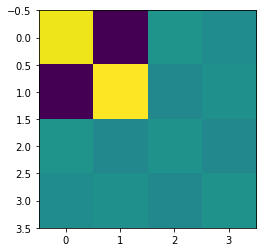

   4.75962    -4.8477   0.239266  -0.0487519  
   -4.8477    5.00614  -0.245751   0.0801754  
  0.239266  -0.245751   0.206062   -0.256947  
-0.0487519  0.0801754  -0.256947    0.210635  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1. -1.  0.  0.]
 [-1.  1.  0.  0.]
 [ 0.  0.  1. -1.]
 [ 0.  0. -1.  1.]]
 5  -5      0      0  
-5   5      0      0  
 0   0   0.25  -0.25  
 0   0  -0.25   0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
0.00885528  
 -0.285474  
   19.6689  
  -20.3765  
y true = 
  0  
  0  
 21  
-21  
arg q-func : 
[[0.5]]
[0.26349999999999996] [0.23975006109347674]
beta 0.25
MM : 

 0.951924  -0.969539   0.457408  -0.287007  
-0.969539    1.00123  -0.469718   0.321623  
 0.457408  -0.469718   0.953502   -1.10773  
-0.287007   0.321623   -1.10773   0.873183  
c : 
[0.47619048 0.47619048 0.02380952 0.02380952]


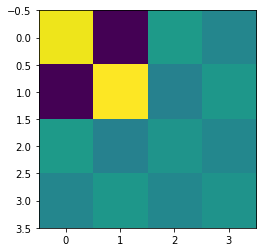

  4.75962    -4.8477   0.511397  -0.320884  
  -4.8477    5.00614  -0.525161   0.359586  
 0.511397  -0.525161   0.238376  -0.276934  
-0.320884   0.359586  -0.276934   0.218296  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.   -1.    0.25 -0.25]
 [-1.    1.   -0.25  0.25]
 [ 0.25 -0.25  1.   -1.  ]
 [-0.25  0.25 -1.    1.  ]]
        5         -5   0.279508  -0.279508  
       -5          5  -0.279508   0.279508  
 0.279508  -0.279508       0.25      -0.25  
-0.279508   0.279508      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 0.273049  
-0.570078  
  19.2604  
 -19.7094  
y true = 
 0.257669  
-0.257669  
  20.3558  
 -20.3558  
arg q-func : 
[[0.51533742]]
[0.26349999999999996, 0.24850000000000005] [0.23975006109347674, 0.23641870497629108]
beta 0.5
MM : 

 0.951924  -0.969539   0.700236  -0.529835  
-0.969539    1.00123  -0.721983   0.573888  
 0.700236  -0.721983    1.10445   -1.19555  
-0.529835   0.573888   -1.19555   0.897859  
c : 
[0.4

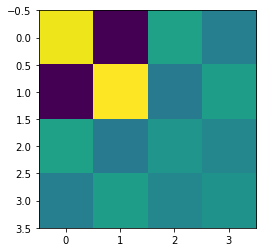

  4.75962    -4.8477   0.782887  -0.592374  
  -4.8477    5.00614  -0.807201   0.641626  
 0.782887  -0.807201   0.276113  -0.298887  
-0.592374   0.641626  -0.298887   0.224465  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.  -1.   0.5 -0.5]
 [-1.   1.  -0.5  0.5]
 [ 0.5 -0.5  1.  -1. ]
 [-0.5  0.5 -1.   1. ]]
        5         -5   0.559017  -0.559017  
       -5          5  -0.559017   0.559017  
 0.559017  -0.559017       0.25      -0.25  
-0.559017   0.559017      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 0.552079  
-0.960878  
  17.4951  
 -17.2983  
y true = 
 0.567568  
-0.567568  
  18.1622  
 -18.1622  
arg q-func : 
[[0.56756757]]
[0.26349999999999996, 0.24850000000000005, 0.235] [0.23975006109347674, 0.23641870497629108, 0.2256135612113705]
beta 0.75
MM : 

 0.951924  -0.969539    0.94223  -0.771829  
-0.969539    1.00123  -0.977664   0.829569  
  0.94223  -0.977664    1.28692   -1.29479  
-0.771829   0.829569   -1.29479   0.913869

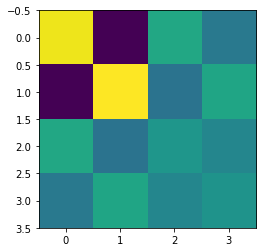

  4.75962   -4.8477    1.05345  -0.862932  
  -4.8477   5.00614   -1.09306   0.927486  
  1.05345  -1.09306    0.32173  -0.323697  
-0.862932  0.927486  -0.323697   0.228467  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1.   -1.    0.75 -0.75]
 [-1.    1.   -0.75  0.75]
 [ 0.75 -0.75  1.   -1.  ]
 [-0.75  0.75 -1.    1.  ]]
        5         -5   0.838525  -0.838525  
       -5          5  -0.838525   0.838525  
 0.838525  -0.838525       0.25      -0.25  
-0.838525   0.838525      -0.25       0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
0.897687  
-1.60334  
 13.6167  
-11.8996  
y true = 
 1.02439  
-1.02439  
 13.3171  
-13.3171  
arg q-func : 
[[0.68292683]]
[0.26349999999999996, 0.24850000000000005, 0.235, 0.205] [0.23975006109347674, 0.23641870497629108, 0.2256135612113705, 0.20429034966232495]
beta 1.0
MM : 

 0.951924  -0.969539    1.1805   -1.0101  
-0.969539    1.00123   -1.2486    1.1005  
   1.1805    -1.2486   1.61005  -1.44502  
  -1.0101     1.1

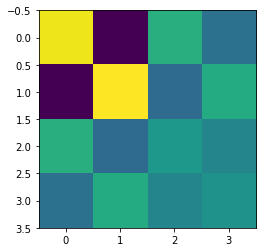

 4.75962   -4.8477    1.31984   -1.12933  
 -4.8477   5.00614   -1.39597     1.2304  
 1.31984  -1.39597   0.402512  -0.361254  
-1.12933    1.2304  -0.361254     0.2228  
e3 - e4 : 
 0  
 0  
 1  
-1  
MM True = 
[[ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]
 [ 1. -1.  1. -1.]
 [-1.  1. -1.  1.]]
       5        -5   1.11803  -1.11803  
      -5         5  -1.11803   1.11803  
 1.11803  -1.11803      0.25     -0.25  
-1.11803   1.11803     -0.25      0.25  
c0 :  0.047619047619047616
e3 - e4 : 
 0  
 0  
 1  
-1  
y = 
 1.17387  
-3.14005  
 6.76583  
 1.55053  
y true = 
 1.90909  
-1.90909  
 1.90909  
-1.90909  
arg q-func : 
[[0.95454545]]
[0.26349999999999996, 0.24850000000000005, 0.235, 0.205, 0.1425] [0.23975006109347674, 0.23641870497629108, 0.2256135612113705, 0.20429034966232495, 0.16428249171959852]
Erreur relative moyenne pour n=2100 et p=100, moyennée sur 10 simulations
0.0655663953691703
Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estim

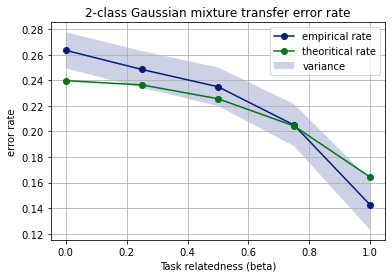

In [48]:
# %%prun -s cumulative
# profiling
p = 100
m = 2
t = 2
beta = np.linspace(0,1,5)
n_t = [[1000, 1000], [50, 50]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

temps_MM = []
temps_estim = []
temps_inference = []
random_state = 100

for b in beta:
    # on crée les données synthétiques
    M = mean_matrix(p, b, t, random_seed=random_state)
    
    X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M, random_state)
    X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]], random_state)

# DEBUG
    #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
    # On calcule les moyennes empiriques
    
    t0 = time()
    MM = empirical_mean(t, m, X, p, n_t)
    print("MM : \n")
    temps_MM.append(time() - t0)
    matprint(MM)
    # On time le calcul de MTM

    t0 = time()
    c = estimate_c(n_t, n, t, m)
    print("c : ")
    print(c)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM, display=True)
    matprint(correlation_matrix)
    y = label_evaluation(t,m,Dc,MM, c0)
    temps_estim.append(time() - t0)
    # On time l'estimation de y, M, et c
    
    M_true = true_mean(M, p, t, m)
    MM_true = M_true.T@M_true
    print("MM True = ")
    print(MM_true)
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    matprint(correlation_matrix_true)
    print("c0 : ", c0)
    y_true = label_evaluation(t,m,Dc,MM_true, c0)
    print("y = ")
    matprint(y)
    print("y true = ")
    matprint(y_true)
    X = normalisation(X, p)
    X_test = normalisation(X_test, p)
    X_train_aggregated = aggregate_array(X, p, n, t, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    
    
    t0 = time()
    J = create_J(m, t, n, n_t)
    V = compute_V(y, X_train_aggregated, J, n)
    
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
    # pour l'instant pas vraiment utilisé
    m_t = create_mt(t, m, y, Dc, correlation_matrix)
    erreur_empirique = compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0)
    temps_inference.append(time() - t0)
    
    V_true = compute_V(y_true, X_train_aggregated, J, n)
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true)
    erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(erreur_empirique)
    th_rate.append(erreur_theorique)
    relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
    print(emp_rate, th_rate)
    
erreur_relative_moy = np.mean(relative_error_rate)
print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")
print(erreur_relative_moy)

print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {np.mean(temps_MM)}, {np.mean(temps_estim)}, {np.mean(temps_inference)}")

print(f"Temps total moyen : {round(np.mean(temps_MM)+np.mean(temps_estim)+np.mean(temps_inference), 3)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [70]:
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
print(n)
print("c0 : ", c0)
print(c)
print("y true = ")
matprint(y_true)

1600
c0 :  0.0625
[0.25  0.25  0.125 0.125 0.125 0.125]
y true = 
 1.88235  
-1.88235  
 1.88235  
-1.88235  
 1.88235  
-1.88235  


Results when doubling n and p proportionately: 
[0.244, 0.2395, 0.23624999999999996, 0.23624999999999996, 0.22999999999999998, 0.2195, 0.21050000000000002, 0.195, 0.17700000000000005, 0.15674999999999994] 
[0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]

In [ ]:
erreur_relative_prec = 0.054
erreur_relative_moy = np.mean(relative_error_rate)
print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations et {nt} données de test : {round(erreur_relative_moy, 3)}")

print(f"En doublant n et p proportionnellement, l'erreur relative moyenne est divisé par un facteur {(1/(erreur_relative_prec/erreur_relative_moy))}")


print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {round(np.mean(temps_MM), 5)} s, {round(np.mean(temps_estim), 5)} s, {round(np.mean(temps_inference), 5)} s.\nLe temps total moyen est ainsi de {round(np.mean(temps_estim) + np.mean(temps_MM) , 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [133]:
%matplotlib qt
debug_histogram(V, X_test_aggregated.T, n_t_test)

# Adding tasks

random
beta 0.5434049417909654
random
beta 0.5434049417909654
c : 
[0.47619048 0.47619048 0.02380952 0.02380952]


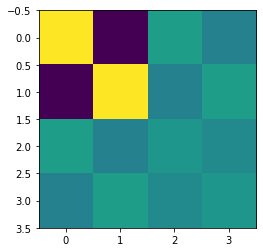

arg q-func : 
[[0.58181058]]
random
beta 0.5434049417909654
random
beta 0.27836938509379616
random
beta 0.4245175907491331
c : 
[0.23809524 0.23809524 0.01190476 0.01190476 0.23809524 0.23809524
 0.01190476 0.01190476]


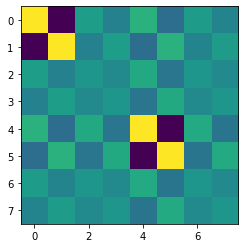

arg q-func : 
[[0.95974685]]
random
beta 0.5434049417909654
random
beta 0.27836938509379616
random
beta 0.4245175907491331
random
beta 0.8447761323199037
random
beta 0.004718856190972565
c : 
[0.15873016 0.15873016 0.00793651 0.00793651 0.15873016 0.15873016
 0.00793651 0.00793651 0.15873016 0.15873016 0.00793651 0.00793651]


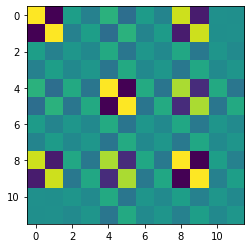

arg q-func : 
[[0.95362444]]
random
beta 0.5434049417909654
random
beta 0.27836938509379616
random
beta 0.4245175907491331
random
beta 0.8447761323199037
random
beta 0.004718856190972565
random
beta 0.12156912078311422
random
beta 0.6707490847267786
c : 
[0.11904762 0.11904762 0.00595238 0.00595238 0.11904762 0.11904762
 0.00595238 0.00595238 0.11904762 0.11904762 0.00595238 0.00595238
 0.11904762 0.11904762 0.00595238 0.00595238]


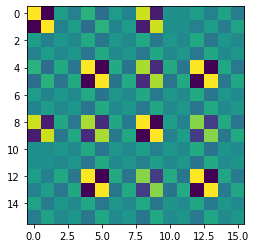

arg q-func : 
[[0.98364767]]
random
beta 0.5434049417909654
random
beta 0.27836938509379616
random
beta 0.4245175907491331
random
beta 0.8447761323199037
random
beta 0.004718856190972565
random
beta 0.12156912078311422
random
beta 0.6707490847267786
random
beta 0.8258527551050476
random
beta 0.13670658968495297
c : 
[0.0952381 0.0952381 0.0047619 0.0047619 0.0952381 0.0952381 0.0047619
 0.0047619 0.0952381 0.0952381 0.0047619 0.0047619 0.0952381 0.0952381
 0.0047619 0.0047619 0.0952381 0.0952381 0.0047619 0.0047619]


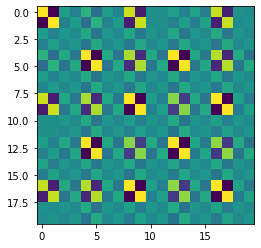

arg q-func : 
[[0.97888233]]
Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : 0.03507399559020996, 0.0011370182037353516, 0.08398818969726562


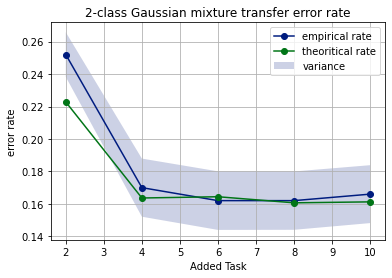

In [71]:
# %%prun -s cumulative
# profiling
p = 100
m = 2
# on ajoute des tâches 2 par 2
nb_tasks = 6
t = range(2,2*nb_tasks, 2)
multiple = 1
to_add = [1000, 1000], [50, 50]
n_t = []
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

# temps
temps_MM = 0
temps_estim = 0
temps_inference = 0
t_total_nd = []
random_state = 100

# données envoyées
data_sent_nd = []
task_target = 1
M = mean_matrix(p, beta=None, k=2, random_seed=random_state, random=True)
X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]], random_state)
X_test = normalisation(X_test, p)

for b in t:
    n_t.append(to_add[0])
    n_t.append(to_add[1])
    
#     print(b)
#     print(n_t)
    n = sum(list(map(sum, (n_t[i] for i in range(b)))))
#     print(n)
    # on crée les données synthétiques
    M = mean_matrix(p, beta=None, k=b, random_seed=random_state, random=True)
       
    X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M, random_state)

# DEBUG
    #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
    # On calcule les moyennes empiriques
    
    t0 = time()
    MM = empirical_mean(b, m, X, p, n_t)
    temps_MM = time() - t0
    # On time le calcul de MTM

    t0 = time()
    c = estimate_c(n_t, n, b, m)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM, display=False)
    y = label_evaluation(b,m,Dc,MM, c0, task_target=task_target)
    temps_estim = time() - t0
    # On time l'estimation de y, M, et c
    
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=True)
    y_true = label_evaluation(b,m,Dc,MM_true, c0, task_target=task_target)
    X = normalisation(X, p)
    
    X_train_aggregated = aggregate_array(X, p, n, b, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true)
    t0 = time()
    J = create_J(m, b, n, n_t)
    V = compute_V(y, X_train_aggregated, J, n)
    V_true = compute_V(y_true, X_train_aggregated, J, n)
    m_t = create_mt(b, m, y, Dc, correlation_matrix)
    erreur_empirique = compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0)
    temps_inference = time() - t0
    # On time le temps d'inférence 
    
    
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    
    erreur_theorique = error_rate(b, m,  Dc, MM_true, c0, task_target=task_target)[0][0]
    emp_rate.append(erreur_empirique)
    th_rate.append(erreur_theorique)
    relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
    t_total_nd.append(temps_MM + temps_estim)
    data_sent_nd.append(n)
    
# erreur_relative_moy = np.mean(relative_error_rate)
# print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")
# print(erreur_relative_moy)

print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {np.mean(temps_MM)}, {np.mean(temps_estim)}, {np.mean(temps_inference)}")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(t, emp_rate, '-o', label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [72]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(range(len(emp_rate)), emp_rate, '-o', label='empirical rate')
plt.plot(range(len(emp_rate)), th_rate, '-o', label='theoritical rate')
plt.fill_between(range(len(emp_rate)), lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

# Algorithme distribué k tâches 2 classes
Bien que certains résultats du précedent algorithmes sont particulèrement inquiétants, essayons de voir comment distribuer l'algorithme sur plusieurs serveurs.

Par exemple un serveur demande les moyennes des autres serveurs pour pouvoir obtenir des meilleurs résultats en calculant la moyenne des ses données et la moyenne de toutes les moyennes avant de le renvoyer au serveur principal qui mettra à jour le modèle.

Prendre des données synthétiques pour la 1ère tâche à 2 classes, puis rappatrier une ou plusieurs moyennes pour les autres tasks. 
Faire des comparaisons, avec et sans federated learning.

### k serveurs 
#### Federated Learning 2 classes k taches
Imaginons 1 Serveur central et k clients. L'un cherche à classifier un certain type d'images, l'autre un deuxième type d'images. Les deux clients sont confrontés un problème de classification binaire sur des images sensiblement similaire (quantifié par le paramètre $\beta$), et peuvent donc s'aider du training de l'autre pour affiner leur classification.

Le premier client entraîne son modèle de classification sur son jeu de données locales. Il espère obtenir de meilleures performances à l'aide du transfer Learning. Les deux clients envoient alors les moyennes empiriques calculées sur leurs donnée locales, au serveur central. Le serveur peut alors calculé la matrice de corrélation $\mathcal{M}$ et les labels optimaux $\tilde{y}$. Les clients recoivent les labels optimaux, et peuvent maintenant recalculer le vecteur propre $V$ de $\displaystyle\frac{X_ty_ty_t^TX_t^T}{np}$ et inférer sur de nouvelles données $x$.

Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

Chaque client calcule en local les moyennes empiriques des données et les envoie au serveur central.

De la même façcon que précédemment les données de chaque client (=chaque tâche) devront respecter les conditions de non-trivialité.

In [96]:
def empirical_mean_old(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data 
    retourne la matrice M de taille px4
    nb_classes=2 (toujours)
    
    Complexité : 
    -------------
    O(k*p*n_tl) = O(n*p)
    """
    M = np.empty((nb_classes*nb_tasks, p))
    diag = []
    for t in range(nb_tasks):
        # O(k)
        for l in range(nb_classes):
            # O(2)
            M[t*nb_classes+l] = X[t][l].dot(np.ones((n_t[t][l])))
            # O(p*n_tl)
            M[t*nb_classes+l] /= n_t[t][l]
            # O(1)
            
            moitie = int(n_t[t][l]/2)
#             print("shape X : ", X[t][l].T[:moitie].T.shape)
            mu1 = 1/moitie*X[t][l].T[:moitie].T@np.ones((moitie))
            mu2 = 1/moitie*X[t][l].T[moitie:2*moitie].T@np.ones((moitie))
            # O(p*n_tl)
            mu1, mu2 = np.reshape(mu1, (p, 1)), np.reshape(mu2, (p, 1))
#             print(mu1.shape)
#             print(mu2.shape)
            diag.append(mu1.T@mu2)
            # O(1)
    
    return M.T, diag

# diag1 = [mu1]
#diag_means = [[mu1], [mu2]]

def gather_empirical_mean(nb_tasks, nb_classes, emp_means, diag_means, p, n_t):
    """
    emp_means est un vecteur contenant les moyennes empiriques de chaque tache de chaque classe.
    Chaque vecteur de moyennes et de taille px1
    Renvoie la matrice M des, produits scalaires entre moyennes empiriques de chaque client
    """
    M = np.empty((2*nb_tasks, 2*nb_tasks)) # ici 4x4
    for i in range(nb_tasks):
        # O(k)
        for j in range(nb_classes):
            # O(2)
            for k in range(nb_tasks):
                # O(k)
                for l in range(nb_classes):
                    # O(2)
                    if i == k and j == l:
                        #print(f"i = {i}, j = {j}")
#                         print(i*nb_tasks+j, i*nb_tasks+j)
#                         print(moitie)
#                         print(np.ones((moitie, 1)).T.dot(X[i][j].T[:moitie]).shape)
#                         print(emp_means[i*nb_tasks+j][:moitie].T.shape)
                        M[i*nb_classes+j][i*nb_classes+j] = diag_means[i*nb_classes+j]
                    else:
#                         print(i*nb_tasks+j, k*nb_tasks+l)
#                         print(emp_means[i*nb_tasks+j].T.shape)
#                         print(emp_means[k*nb_tasks+l].shape)
                        M[i*nb_classes+j][k*nb_classes+l] = emp_means[i*nb_classes+j].T.dot(emp_means[k*nb_classes+l])
                    # O(p)
#                         print(M[i*nb_tasks+j][k*nb_tasks+l].shape)
                
    return M

In [208]:
def merging_center(MM, diag, t, m, p, n, n_t, task_target=None, display=False):
    """
    Recoit les moyennes empiriques des k clients, calcule la matrice de corrélation, les labels optimaux et renvoie le vecteur V
    Renvoie y un vecteur de labels optimaux adapté à chaque client. (à changer?)
    """
    # MM = [[MM11, MM12], [MM21, MM22], [MM31, MM32], ...]
    emp_means = []
    diagonal = []
    
    for i in range(len(MM)):
        emp_means.append(np.reshape(MM[i].T[0], (p, 1)))
        emp_means.append(np.reshape(MM[i].T[1], (p, 1)))
        diagonal.append(diag[i][0])
        diagonal.append(diag[i][1])
    #diag = [diag1[0], diag1[1], etc.]
    #emp_means = [MM11, MM12, MM21, MM22, MM31, ...]
    MM_gathered = gather_empirical_mean(t, m, emp_means, diagonal, p, n_t)
    print("MM_gathered : ")
    matprint(MM_gathered)
    
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
#     print("c = ", c)
#     print("Correlation Matrix : ")
    correlation_matrix = compute_M_cal(n, p, Dc, MM_gathered, display=display)
    
    # faire une label evaluation en fonction de la 
    # faire une boucle sur tous les clients ?
    y = label_evaluation(t,m,Dc,MM_gathered, c0, task_target=task_target)
    matprint(y)
    
    # le serveur calcule aussi
    V = np.zeros((p,1))
    for i in range(t):
        for j in range(m):
            print(emp_means[i*m+j].shape)
            V += n_t[i][j]*emp_means[i*m+j]*y[i*m+j]
#     print(f"V = {V}")
      # essayer de comprendre pourquoi diviser par la norme fait tout foirer et donne zero
    V = np.reshape(V, (p))
    V = V.astype("float128")
    print(V[:10], np.linalg.norm(V))
    V /= np.linalg.norm(V)
    
    return V, y, correlation_matrix, Dc, c0

MM_gathered : 
0.0159666  0.0154204  0.0118236  0.0117025  0.0113665  0.0109643  0.0121114  0.0115907  
0.0154204  0.0158494  0.0120443  0.0130034  0.0115568  0.0120657  0.0124608  0.0128264  
0.0118236  0.0120443  0.0167885  0.0155211  0.0131703  0.0126336  0.0168945  0.0152219  
0.0117025  0.0130034  0.0155211  0.0168666  0.0130088  0.0137245  0.0161433  0.0165941  
0.0113665  0.0115568  0.0131703  0.0130088  0.0139936  0.0134011  0.0135405  0.0127822  
0.0109643  0.0120657  0.0126336  0.0137245  0.0134011  0.0140708  0.0131465  0.0134813  
0.0121114  0.0124608  0.0168945  0.0161433  0.0135405  0.0131465  0.0180559  0.0162434  
0.0115907  0.0128264  0.0152219  0.0165941  0.0127822  0.0134813  0.0162434  0.0167144  


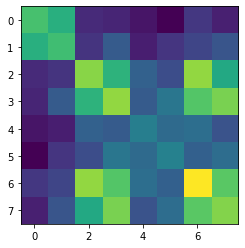

0.00271508  
-0.0133238  
 0.0198357  
-0.0190522  
0.00330573  
-0.0153177  
 0.0121644  
-0.0194604  
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
[ 0.64816309 -1.72501032 -1.15843202  0.26019469  0.19566239  0.19600942
 -0.29795101 -0.25918338  0.19323005  0.06146346] 4.0337461493806320164


In [209]:
V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, True)

In [194]:
print(V.dtype)

float64


0.0
[array([[0.95192386]]), array([[1.0012283]])]
[array([[0.82424997]]), array([[0.84253941]])]


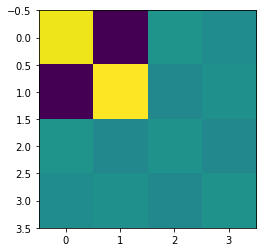

e3 - e4 : 
 0  
 0  
 1  
-1  
   4.75962    -4.8477   0.239266  -0.0487519  
   -4.8477    5.00614  -0.245751   0.0801754  
  0.239266  -0.245751   0.206062   -0.256947  
-0.0487519  0.0801754  -0.256947    0.210635  
0.1111111111111111
[array([[0.95192386]]), array([[1.0012283]])]
[array([[0.87925669]]), array([[0.85682921]])]


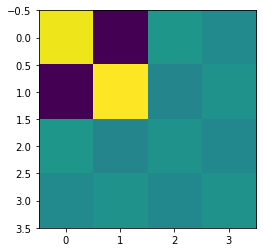

e3 - e4 : 
 0  
 0  
 1  
-1  
  4.75962    -4.8477   0.360285  -0.169771  
  -4.8477    5.00614  -0.369638   0.204062  
 0.360285  -0.369638   0.219814  -0.265609  
-0.169771   0.204062  -0.265609   0.214207  
0.2222222222222222
[array([[0.95192386]]), array([[1.0012283]])]
[array([[0.93814905]]), array([[0.87005051]])]


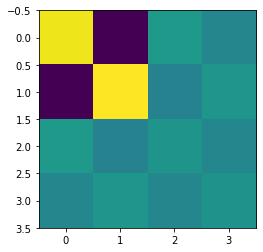

e3 - e4 : 
 0  
 0  
 1  
-1  
  4.75962    -4.8477    0.48119  -0.290676  
  -4.8477    5.00614  -0.493995    0.32842  
  0.48119  -0.493995   0.234537  -0.274623  
-0.290676    0.32842  -0.274623   0.217513  
0.3333333333333333
[array([[0.95192386]]), array([[1.0012283]])]
[array([[1.00115954]]), array([[0.88213938]])]


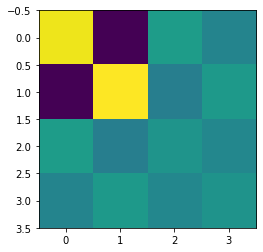

e3 - e4 : 
 0  
 0  
 1  
-1  
  4.75962    -4.8477   0.601973  -0.411459  
  -4.8477    5.00614  -0.618852   0.453277  
 0.601973  -0.618852    0.25029   -0.28401  
-0.411459   0.453277   -0.28401   0.220535  
0.4444444444444444
[array([[0.95192386]]), array([[1.0012283]])]
[array([[1.06873171]]), array([[0.89297387]])]


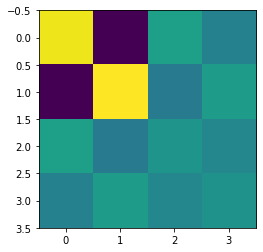

e3 - e4 : 
 0  
 0  
 1  
-1  
  4.75962    -4.8477   0.722621  -0.532107  
  -4.8477    5.00614  -0.744262   0.578687  
 0.722621  -0.744262   0.267183  -0.293811  
-0.532107   0.578687  -0.293811   0.223243  
0.5555555555555556
[array([[0.95192386]]), array([[1.0012283]])]
[array([[1.14163799]]), array([[0.90234155]])]


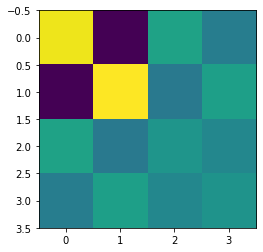

e3 - e4 : 
 0  
 0  
 1  
-1  
  4.75962    -4.8477   0.843111  -0.652597  
  -4.8477    5.00614  -0.870319   0.704743  
 0.843111  -0.870319   0.285409  -0.304095  
-0.652597   0.704743  -0.304095   0.225585  
0.6666666666666666
[array([[0.95192386]]), array([[1.0012283]])]
[array([[1.22125531]]), array([[0.90986379]])]


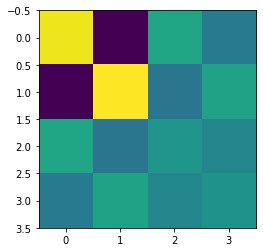

e3 - e4 : 
 0  
 0  
 1  
-1  
  4.75962    -4.8477   0.963402  -0.772889  
  -4.8477    5.00614  -0.997188   0.831613  
 0.963402  -0.997188   0.305314  -0.314988  
-0.772889   0.831613  -0.314988   0.227466  
0.7777777777777777
[array([[0.95192386]]), array([[1.0012283]])]
[array([[1.31032296]]), array([[0.91478733]])]


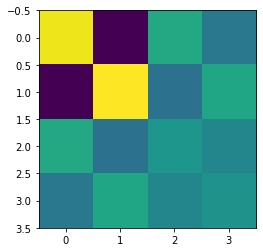

e3 - e4 : 
 0  
 0  
 1  
-1  
  4.75962   -4.8477    1.08341  -0.892901  
  -4.8477   5.00614    -1.1252   0.959628  
  1.08341   -1.1252   0.327581  -0.326737  
-0.892901  0.959628  -0.326737   0.228697  
0.8888888888888888
[array([[0.95192386]]), array([[1.0012283]])]
[array([[1.41589383]]), array([[0.91517273]])]


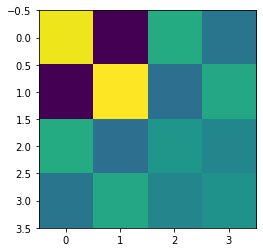

e3 - e4 : 
 0  
 0  
 1  
-1  
 4.75962   -4.8477    1.20294   -1.01243  
 -4.8477   5.00614   -1.25522    1.08964  
 1.20294  -1.25522   0.353973  -0.339981  
-1.01243   1.08964  -0.339981   0.228793  
1.0
[array([[0.95192386]]), array([[1.0012283]])]
[array([[1.61004846]]), array([[0.89119891]])]


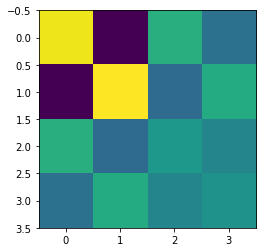

e3 - e4 : 
 0  
 0  
 1  
-1  
 4.75962   -4.8477    1.31984   -1.12933  
 -4.8477   5.00614   -1.39597     1.2304  
 1.31984  -1.39597   0.402512  -0.361254  
-1.12933    1.2304  -0.361254     0.2228  
temps moyen clients : 0.00093, 0.01507
temps moyen Serveur central : 0.18465
temps total moyen : 0.20065


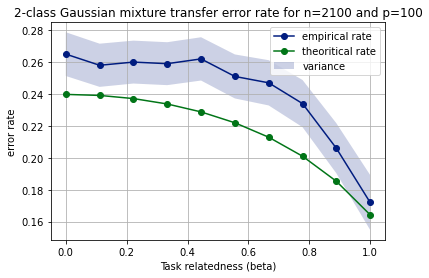

In [33]:
n1 = 2000
n2 = 100
n = n1+n2
p = 100
m = 2
t = 2
ni = [n1, n2]
beta = np.linspace(0,1,10)
n_t = [[int(n1/2),int(n1/2)], [int(n2/2), int(n2/2)]]
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
emp_rate, th_rate, var = [], [], []

t_MM = []
t_SC = []
t_inf = []
t_MM_f = []
t_inf_f = []

random_state = 100
task_target = 1

for b in beta:
    # on crée les données synthétiques
    M = mean_matrix(p, b, t, random_seed=random_state)
#       print(M)
    # X1 is the local data of the first client
    # normalisation?
    X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M, random_state)
    
    # data we want to test on our model, here new data of client n°2
    X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]], random_state)
    
    MM = []
    diag = []
    
    # On calcule les moyennes empiriques sur les données locales
    # diag1 = [diag1[0], diag1[1]]
    for i in range(t):
        t0 = time()
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        t_MM.append(time()-t0)
        MM.append(MM1)
        diag.append(diag1)
    X = normalisation(X, p)

# CENTRAL SERVER
    t0 = time()
    # sending empirical means to central server
    # y est un vecteur de vecteurs de labels optimaux
    V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target)
    t_SC.append(time()-t0)
    matprint(correlation_matrix)
    
    # when to normalize the data ?
    X_test = normalisation(X_test, p)

# END CENTRAL SERVER

    # Sending back optimal labels to clients
    aggregated = []
    for i in range(t):
        aggregated.append(aggregate_array([X[i]], p, ni[i], 1, m))
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    # ou alors créer un J ?
#     J = create_J(m, 2, n, n_t)
    
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    
#     debug_histogram(V, X_test_aggregated, n_t_test)
#     print("V = ")
#     print(V)
    t0 = time()
    m_t = create_mt(t, m, y, Dc, correlation_matrix)
    
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))
    t_inf.append(time()-t0)
#     th_rate.append(error_rate(t, m,  Dc, MM_true, c0)[0][0])
#     print(emp_rate, th_rate)
    t_MM_f.append(max(t_MM))
    t_inf_f.append(max(t_inf))
    
# pour pas le recalculer a chaque fois 
th_rate = [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]   

print(f"temps moyen clients : {round(np.mean(t_MM_f), 5)}, {round(np.mean(t_inf_f), 5)}")
print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)}")
print(f"temps total moyen : {round(np.mean(t_MM_f), 5) + round(np.mean(t_inf_f), 5) + round(np.mean(t_SC), 5)}")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [ ]:
4.75962   -4.8477    1.08341  -0.892901  
  -4.8477   5.00614    -1.1252   0.959628  
  1.08341   -1.1252   0.327581  -0.326737  
-0.892901  0.959628  -0.326737   0.228697 

In [46]:
print(i)

2


temps moyen clients (calcul moyennes, inférence): 0.00093 s, 0.01507 s
temps moyen Serveur central : 0.18465 s
temps total moyen : 0.20065 s


ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

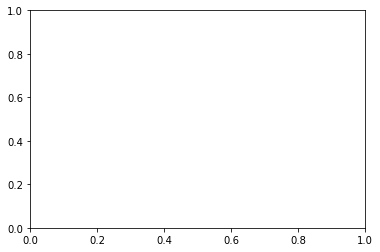

In [70]:
th_rate = [0.23975006109347674, 0.23910189492427802, 0.23712834068265354, 0.23373859215337528, 0.2287682743173643, 0.22195637062121154, 0.2129043075952785, 0.20100393554334806, 0.18530737544421827, 0.16428249171959852]   

print(f"temps moyen clients (calcul moyennes, inférence): {round(np.mean(t_MM_f), 5)} s, {round(np.mean(t_inf_f), 5)} s")
print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)} s")
print(f"temps total moyen : {round(np.mean(t_MM_f), 5) + round(np.mean(t_inf_f), 5) + round(np.mean(t_SC), 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Distributively adding tasks

random
beta 0.3745401188473625
random
beta 0.3745401188473625
MM_gathered : 
  1.00989   -1.00613   0.439756  -0.359996  
 -1.00613    1.03729  -0.466749   0.384811  
 0.439756  -0.466749    1.33263   -1.05871  
-0.359996   0.384811   -1.05871    1.04691  
 0.248217  
-0.336668  
  4.47282  
 -4.03944  
(200, 1)
(200, 1)
(200, 1)
(200, 1)
[1133.75005489 -241.18754561   35.42522789   53.57148234   44.88094283
   69.98129978 -125.81363404   57.09439625  -64.73541293 -121.44882172] 2745.9912331842625162


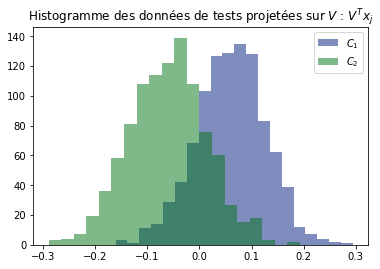

arg q-func : 
[[0.72469802]]
random
beta 0.3745401188473625
random
beta 0.9507143064099162
random
beta 0.7319939418114051
MM_gathered : 
  1.00989   -1.00613   0.439756  -0.359996   0.984699  -0.981338   0.736296  -0.869464  
 -1.00613    1.03729  -0.466749   0.384811  -0.950418   0.937085  -0.733073   0.711275  
 0.439756  -0.466749    1.33263   -1.05871   0.728542  -0.707036    1.10882  -0.924071  
-0.359996   0.384811   -1.05871    1.04691  -0.579319   0.680197    -1.0202   0.837584  
 0.984699  -0.950418   0.728542  -0.579319   0.961304  -0.967678   0.860329   -0.84014  
-0.981338   0.937085  -0.707036   0.680197  -0.967678    1.04572  -0.951479   0.874853  
 0.736296  -0.733073    1.10882    -1.0202   0.860329  -0.951479    1.17599  -0.994564  
-0.869464   0.711275  -0.924071   0.837584   -0.84014   0.874853  -0.994564   0.956786  
-1.88968  
0.505847  
 6.33996  
-5.27863  
 1.38463  
-1.15299  
  4.3345  
-3.53527  
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)


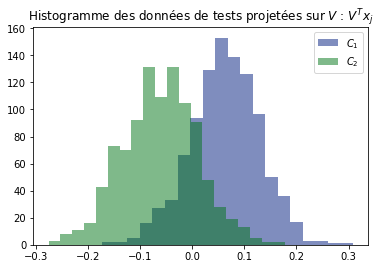

arg q-func : 
[[0.80977304]]


In [223]:
# %%prun -s cumulative
%matplotlib inline
# profiling
p = 200
m = 2
# on ajoute des tâches 2 par 2
nb_tasks = 3
step = 2
t = range(2,step*nb_tasks, step)
multiple = 1
to_add = [500, 500], [250, 250]
n_t = []
n_t_test = [[1000, 1000]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

# temps
t_SC = 0
t_inf = []
t_MM_f = 0
t_inf_f = 0
t_total_d = []
t_SC_d = []
random_state = 42

# données envoyées de taille p
data_sent = []

# on définit la tache cible
task_target = 1

M = mean_matrix(p, beta=None, k=2, random_seed=random_state, random=True)
X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]], random_state)
X_test = normalisation(X_test, p)

for b in t:
    t_MM = []
    sent = 0
    n_t.append(to_add[0])
    n_t.append(to_add[1])
    
    n = sum(list(map(sum, (n_t[i] for i in range(b)))))
#     print("n = ", n)
    # on crée les données synthétiques
    M = mean_matrix(p, beta=None, k=b, random_seed=random_state, random=True)
       
    X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M, random_state)
    MM = []
    diag = []
    
    # On calcule les moyennes empiriques sur les données locales de chaque serveur
    # diag1 = [diag1[0], diag1[1]]
    for i in range(b):
        t0 = time()
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        # chaque moyenne empirique calculée est un vecteur de taille p
        sent+=1
        t_MM.append(time()-t0)
        
        MM.append(MM1)
        diag.append(diag1)

    # CENTRAL SERVER
    t0 = time()
    # sending empirical means to central server
    V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, b, m, p, n, n_t, task_target)   
    #V_true, y_true, correlation_matrix_true, Dc, c0 = merging_center(M_true, diag_true, b, m, p, n_t, task_target)
    t_SC = time()-t0
    
    # END CENTRAL SERVER
    # a prendre en compte dans le timing
    X = normalisation(X, p)
    
    X_train_aggregated = aggregate_array(X, p, n, b, m)
    X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
    # On time le temps d'inférence
    
    # Calcul avec les vraies moyennes
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(b,m,Dc, MM_true, c0, task_target=task_target)
    
#     V_true = compute_V(y_true, X_train_aggregated, J, n)
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
    VTX = V.T@X_test_aggregated
    var.append(np.var(VTX))
    debug_histogram(V, X_test_aggregated, n_t_test)
    
    t0 = time()
    m_t = create_mt(b, m, y, Dc, correlation_matrix)
    
    erreur_theorique = error_rate(b, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))
    th_rate.append(erreur_theorique)
    t_inf.append(time()-t0)
    t_MM_f = max(t_MM)
    t_inf_f = max(t_inf)
    t_total_d.append(t_MM_f + t_SC)
    t_SC_d.append(t_SC)
    data_sent.append(sent)

# print(f"temps moyen clients : {round(np.mean(t_MM_f), 5)}, {round(np.mean(t_inf_f), 5)}")
# print(f"temps moyen Serveur central : {round(np.mean(t_SC), 5)}")
# print(f"temps total moyen : {round(np.mean(t_MM_f), 5) + round(np.mean(t_inf_f), 5) + round(np.mean(t_SC), 5)}")

In [222]:
print(n_t)

[[500, 500], [250, 250]]


In [90]:
print(data_sent)
print(data_sent_nd)
print(t_SC_d)
print(t_total_d)
print(th_rate)

[2, 4, 6, 8, 10, 12, 14, 16, 18]
[2100, 4200, 6300, 8400, 10500]
[0.0006132125854492188, 0.0007386207580566406, 0.0012683868408203125, 0.0018301010131835938, 0.0036993026733398438, 0.0035157203674316406, 0.006444215774536133, 0.006421804428100586, 0.00941157341003418]
[0.0014486312866210938, 0.0015006065368652344, 0.0024559497833251953, 0.0027616024017333984, 0.004588603973388672, 0.004677772521972656, 0.008049964904785156, 0.007590532302856445, 0.012226581573486328]
[0.19730359169896483, 0.18409367962615064, 0.16952392663218724, 0.16464100094357442, 0.16390025000312758, 0.16287128429045816, 0.16279455537925752, 0.16181543518909547, 0.16123270573877568]


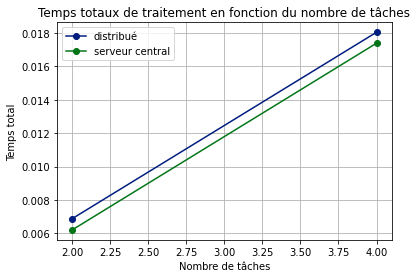

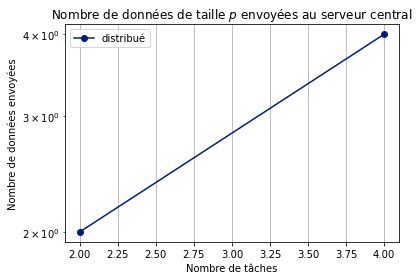

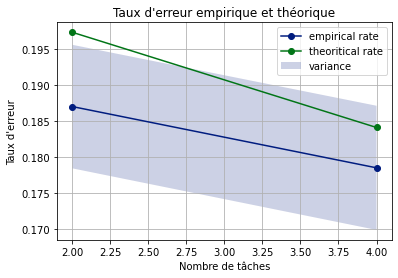

In [224]:
# plot le temps du distribué vs non distribué
plt.plot(data_sent, t_total_d, '-o', label='distribué')
plt.plot(data_sent, t_SC_d, '-o', label='serveur central')
# plt.plot(t, t_total_nd, '-o', label='non distribué')
plt.xlabel("Nombre de tâches")
plt.ylabel("Temps total")
plt.title("Temps totaux de traitement en fonction du nombre de tâches")
plt.legend()
plt.grid()
plt.show()

plt.plot(data_sent, data_sent, "-o", label='distribué')
# plt.plot(t, data_sent_nd, '-o', label='non distribué')
plt.xlabel("Nombre de tâches")
plt.ylabel("Nombre de données envoyées")
plt.yscale("log")
plt.title(r"Nombre de données de taille $p$ envoyées au serveur central")
plt.legend()
plt.grid()
plt.show()

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(data_sent, lower, upper, alpha=0.2, label="variance")
plt.plot(data_sent, emp_rate, "-o", label='empirical rate')
plt.plot(data_sent, th_rate, '-o', label='theoritical rate')
plt.xlabel("Nombre de tâches")
plt.ylabel("Taux d'erreur")
plt.title(r"Taux d'erreur empirique et théorique")
plt.legend()
plt.grid()
plt.show()

In [30]:
print(t_SC)
# le temps passé dans le serveur central augmente avec le nombre de clients (augmente comment ?)

0.3078761100769043


# Real Data

In [210]:
def divide_array(X,y,k,m=2):
    """
    Divide a data ndarray in an array of k arrays of m ndarrays each.
    Return the divided array and the number of elements in each classes of each tasks
    """
    X_data = []
    n_t = []
    for task in range(k):
        n_t.append([])
        X_data.append([])
        n_t1 = np.count_nonzero(y)
        n_t[task].append(n_t1)
        n_t[task].append(len(y) - n_t1)
        X_data[task].append(X[:n_t1].T)
        X_data[task].append(X[n_t1:].T)
        
    return X_data, n_t

n :  3999
[[1000, 1000], [999, 1000]]
MM_gathered : 
0.0159666  0.0154204  0.0118236  0.0117025  
0.0154204  0.0158494  0.0120443  0.0130034  
0.0118236  0.0120443  0.0167885  0.0155211  
0.0117025  0.0130034  0.0155211  0.0168666  


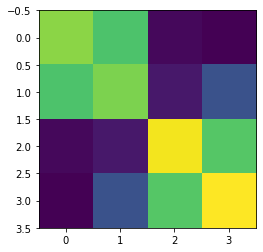

 0.00151086  
-0.00924108  
  0.0128742  
 -0.0131405  
(400, 1)
(400, 1)
(400, 1)
(400, 1)
[ 0.26751429 -0.56369984 -0.38071154  0.14108178  0.05562386  0.12081706
 -0.07908024 -0.06268738  0.10057756  0.04118221] 1.3119127015219087556
0.250063         0         0         0  
       0  0.250063         0         0  
       0         0  0.249812         0  
       0         0         0  0.250063  


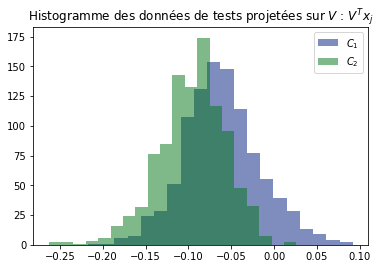

n :  3999
[[1000, 1000], [999, 1000], [999, 1000]]
MM_gathered : 
0.0159666  0.0154204  0.0118236  0.0117025  0.0113665  0.0109643  
0.0154204  0.0158494  0.0120443  0.0130034  0.0115568  0.0120657  
0.0118236  0.0120443  0.0167885  0.0155211  0.0131703  0.0126336  
0.0117025  0.0130034  0.0155211  0.0168666  0.0130088  0.0137245  
0.0113665  0.0115568  0.0131703  0.0130088  0.0139936  0.0134011  
0.0109643  0.0120657  0.0126336  0.0137245  0.0134011  0.0140708  


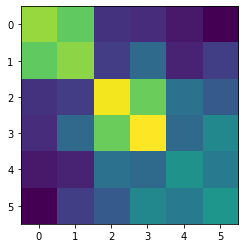

 0.00170505  
-0.00902029  
  0.0131009  
 -0.0128854  
 0.00208923  
 -0.0103577  
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
[ 0.25785141 -0.82974003 -0.65272107  0.13925608  0.06287252  0.1091868
 -0.15248826 -0.14809419  0.10181114  0.0222269 ] 2.0715724964416522215
0.250063         0         0         0         0         0  
       0  0.250063         0         0         0         0  
       0         0  0.249812         0         0         0  
       0         0         0  0.250063         0         0  
       0         0         0         0  0.249812         0  
       0         0         0         0         0  0.250063  


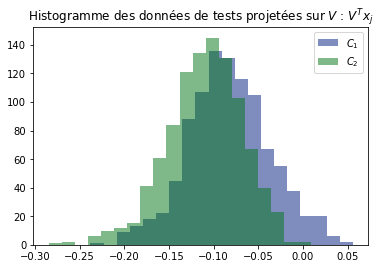

n :  5998
[[1000, 1000], [999, 1000], [999, 1000], [998, 1000]]
MM_gathered : 
0.0159666  0.0154204  0.0118236  0.0117025  0.0113665  0.0109643  0.0121114  0.0115907  
0.0154204  0.0158494  0.0120443  0.0130034  0.0115568  0.0120657  0.0124608  0.0128264  
0.0118236  0.0120443  0.0167885  0.0155211  0.0131703  0.0126336  0.0168945  0.0152219  
0.0117025  0.0130034  0.0155211  0.0168666  0.0130088  0.0137245  0.0161433  0.0165941  
0.0113665  0.0115568  0.0131703  0.0130088  0.0139936  0.0134011  0.0135405  0.0127822  
0.0109643  0.0120657  0.0126336  0.0137245  0.0134011  0.0140708  0.0131465  0.0134813  
0.0121114  0.0124608  0.0168945  0.0161433  0.0135405  0.0131465  0.0180559  0.0162434  
0.0115907  0.0128264  0.0152219  0.0165941  0.0127822  0.0134813  0.0162434  0.0167144  


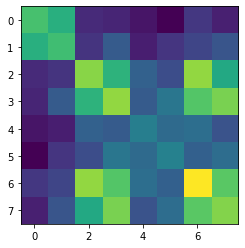

0.00271508  
-0.0133238  
 0.0198357  
-0.0190522  
0.00330573  
-0.0153177  
 0.0121644  
-0.0194604  
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
(400, 1)
[ 0.64816309 -1.72501032 -1.15843202  0.26019469  0.19566239  0.19600942
 -0.29795101 -0.25918338  0.19323005  0.06146346] 4.0337461493806320164
0.166722         0         0         0         0         0         0         0  
       0  0.166722         0         0         0         0         0         0  
       0         0  0.166556         0         0         0         0         0  
       0         0         0  0.166722         0         0         0         0  
       0         0         0         0  0.166556         0         0         0  
       0         0         0         0         0  0.166722         0         0  
       0         0         0         0         0         0  0.166389         0  
       0         0         0         0         0         0         0  0.166722  


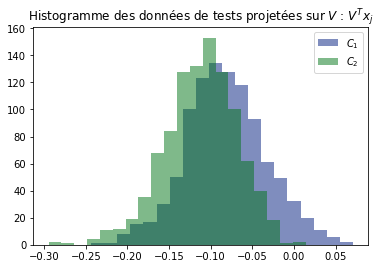

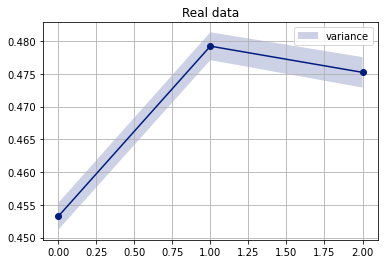

In [230]:
dataset = "amazon"
# dataset = "mnist"
# dataset = "caltech"

from scipy.io import loadmat
m=2
var, emp_rate = [], []
if dataset == "amazon":
    k = 3
    mat = loadmat("books_400.mat")
    mat_test = loadmat("kitchen_400.mat")
    X_test_aggregated, y_test = mat_test['fts'], mat_test['labels']
    X_test, n_t_test = divide_array(X_test_aggregated, y_test, 1)
    # X1 contient toute la premiere tâche
    X1_aggregated, y = mat["fts"], mat["labels"] 
    X, n_t = divide_array(X1_aggregated, y, 1)
    X.append(X_test[0])
    n_t.append(n_t_test[0])
    task_target = 1
    p = X1_aggregated.shape[1]
#     X = normalisation(X, p)
    
for t in range(2, k+2):
#     nt = sum(n_t_test[0])
    # faire quelque chose de généralisable
    n = sum(list(map(sum, (n_t[i] for i in range(len(n_t))))))
    print("n : ", n)
    
    # add tasks
    if t>2:
        if t==3:
            mat = loadmat("dvd_400.mat")
            X2_aggregated, y2 = mat["fts"], mat["labels"] 
            X_tmp, n_t_tmp = divide_array(X2_aggregated, y2, 1)
#             X_tmp = normalisation(X_tmp, p)
            X.append(X_tmp[0])
            n_t.append(n_t_tmp[0])
        elif t==4:
            mat = loadmat("elec_400.mat")
            X3_aggregated, y3 = mat["fts"], mat["labels"] 
            X_tmp, n_t_tmp = divide_array(X3_aggregated, y3, 1)
#             X_tmp = normalisation(X_tmp, p)
            X.append(X_tmp[0])
            n_t.append(n_t_tmp[0])
    print(n_t)
            
    MM = []
    diag = []
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        # chaque moyenne empirique calculée est un vecteur de taille p
#         sent+=1
#         t_MM.append(time()-t0)
        MM.append(MM1)
        diag.append(diag1)

    # CENTRAL SERVER
#     t0 = time()
    # sending empirical means to central server
    V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, True)
    matprint(Dc)
    # END CENTRAL SERVER
#     X_test = normalisation(X_test, p)
    VTX = V.T@X_test_aggregated.T
    debug_histogram(V, X_test_aggregated.T, n_t_test)
    var.append(np.var(VTX))
    m_t = create_mt(t, m, y_opt, Dc, correlation_matrix)
    
#     erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(compute_error_rate(X_test, V, m_t, 1, m, n_t_test, Dc, c0))
    
plt.plot(list(range(k)), emp_rate, '-o')
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(list(range(k)), lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.grid()
plt.title("Real data")
plt.show()

In [220]:
# print(X[3][1].shape)
print(n_t)
print(i)
print(p)
moitie = int(n_t[1][0]/2)
print(emp_rate)
print(n_t_test)
len(X_test)
print(VTX.shape)
print(V)
print(np.linalg.norm(V))

[[1000, 1000], [999, 1000], [999, 1000], [998, 1000]]
3
400
[0.4532266133066533, 0.4532266133066533, 0.4532266133066533]
[[999, 1000]]
(1999,)
[ 2.03657726e-01 -4.29756611e-01 -2.90257701e-01  1.07316819e-01
  4.24217358e-02  9.18618805e-02 -6.03617074e-02 -4.78943310e-02
  7.65165473e-02  3.12917593e-02 -6.96653118e-02 -9.07953150e-02
  5.54247794e-02 -5.13969963e-02  4.30448908e-02 -7.66539240e-02
  3.83520941e-02 -9.57889455e-02  2.49359913e-02 -5.22925053e-02
 -4.62813124e-01 -5.43704886e-02 -5.16476932e-02 -7.03121091e-02
  4.87874176e-02  3.83363925e-02 -9.34755890e-02 -4.35713710e-02
  1.50634089e-02 -7.24057716e-02  3.39021797e-02 -5.23060666e-02
  4.02007703e-02 -1.91495267e-02 -2.88229358e-02  4.87085166e-02
 -3.16592613e-02 -5.15475898e-02 -2.19940358e-02  7.81751249e-03
 -6.25428104e-02 -3.19335232e-02 -7.38274722e-02 -5.81208125e-02
 -1.70969570e-01 -3.13650328e-02 -4.19307109e-02 -5.06585306e-02
 -6.76925838e-03 -1.70008272e-02 -9.35876350e-02 -1.13642730e-01
 -3.19376253

# MNIST


In [231]:
from keras.datasets import mnist
(X_train,y_train), (X_test,y_test)=mnist.load_data()

Using TensorFlow backend.
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/py

11493376/11490434 [==============================] - 23s 2us/step


In [233]:
X_train.shape
X_test.shape

(10000, 28, 28)

# Algorithme distribué k-tâches m classes
On se ramène à un cas 2-tâches 2-classes en fait

In [28]:
from sklearn.preprocessing import normalize

def z_normalize(X, k, m):
    """
    Normalise les données.
    k tâches, m classes
    X le tableau de données.
    """
    for t in range(k):
        for l in range(m):
            X[t][l] = normalize(X[t][l], axis=1)
    return X

In [174]:
# Algorithme 1 du papier
k = 2
m = 10
n1 = [100 for i in range(m)]
n2 = [50 for i in range(m)]
p = 100
n_t = [n1, n2]
n_t_test = [[1000 for i in range(m)]]
nt = sum(n_t_test[0])
# faire quelque chose de généralisable
n = sum(list(map(sum, (n_t[i] for i in range(k)))))
c0 = p/n
var = []
emp_rate = []
scores = []
random_state=100
# si je peux essayer de faire plus dégeu pour le n 
M = mean_matrix(p, k=k, m=m, random_seed=random_state, random=True)
X, y_bs = gaussian_synthetic_data(n, p, m, k, n_t, M, random_state)

# choisir la tache que l'on veut tester
test_task = 1
X_test, y_test = gaussian_synthetic_data(n, p, m, 1, n_t_test, [M[test_task]], random_state)
X, X_test = z_normalize(X, k, m), z_normalize(X_test, 1, m)
# beta = []
# [[[],[]], [[], []]]

# inverser les boucles ?
for l in range(m):
    for t in range(k):
        if t==test_task:
            # how does it benefit from the other tasks?
            # pourquoi faire une boucle sur les tâches ?
    #         beta.append(l*k+t)
            X_data = []
            # on ajoute la premiere classe de la premiere tache
            X_data.append([X[t][l]])
            current_n_t = [[n_t[t][l]]]
            s = 0           

            tmp = np.empty((p, 0), float)
    #         print("tmp : ", tmp)
            for cl in range(m):
                if cl==l:
                    continue
    #             print("on ajoute : ", X[t][cl])
    #             print(X[t][cl].shape)
                tmp = np.concatenate((tmp, X[t][cl]), axis=1)
                s += n_t[t][cl]
    #         print("tmp : ", tmp)
            X_data[0].append(tmp)
    #         qui est la deuxieme tâche ? 
    #         X_data.append(X_test[0])
#             regrouper toutes les autres tâches
#             a reprendre
            temp = []
            tmp1 = np.empty((p, 0), float)
            s1 = 0
            sc = []
            for tp in range(k):
                if tp == test_task:
                    continue
                for l in range(m):
                    tmp1 = np.concatenate((tmp1, X[tp][l]), axis=1)
                    s1 += n_t[tp][l]
                temp.append(tmp1)
                sc.append(s2)
                sc.append(s1)
            X_data.append(temp)
    #         print("len(X) : ", len(X_data))
    #         print("len(X[0]) : ", len(X_data[1][0]))
            current_n_t[0].append(s)
            current_n_t.append(sc)
            print(f"current nt = {current_n_t}")
            MM = empirical_mean(2, 2, X_data, p, current_n_t)
            matprint(MM)
            c = estimate_c(current_n_t, n, 2, 2)
            Dc = np.diag(c)
            matprint(Dc)
            correlation_matrix = compute_M_cal(n, p, Dc, MM, 2, True)

            y = label_evaluation(2, 2, Dc, MM, c0)
            matprint(y)
            X_aggregated = aggregate_array(X_data, p, n, 2, 2)
            X_test_aggregated = aggregate_array(X_test, p, nt, 1, 2)

            # no need to compute V anymore
            J = create_J(2, 2, n, current_n_t)
            V = compute_V(y, X_aggregated, J, n)
            # On time le temps d'inférence

        #     debug_histogram(V_true, X_test_aggregated, n_t_test)
        #     print("V = ")
            VTX = V.T@X_test_aggregated
            var.append(np.var(VTX))
            debug_histogram(V, X_test_aggregated, n_t_test)

            # pour l'instant pas vraiment utilisé
            m_t = create_mt(2, 2, y, Dc, correlation_matrix)
            # gxt in R^1xn

            gxt = y.T@J.T@X_aggregated.T@X_test_aggregated/np.linalg.norm(y.T@J.T@X_aggregated.T)
            gxt = np.reshape(gxt, (nt))
            scores.append(gxt-m_t[0][0])

            erreur_empirique = compute_error_rate(X_test, V, m_t, 1, 2, n_t_test, Dc, c0)
    #         erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
            emp_rate.append(erreur_empirique)
    #         th_rate.append(erreur_theorique)
    #         relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)

estimated_class=[]
for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))

        
        
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(beta, emp_rate, '-o', label='empirical rate')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.legend()
# plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
# plt.xlabel("Task relatedness (beta)")
# plt.ylabel("error rate")
# plt.grid()
# plt.show()
        

current nt = [[50, 450], [0, 1000]]
0 0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 0 is different from 1000)

In [162]:
print(X_data[1][1].shape)

(100, 1000)


In [168]:
estimated_class = []
erreur= []

for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))
    erreur.append(int(np.argmax(classes)==y_test[j]))
    
err = erreur.count(1)/len(scores[0])
if err>0.5:
    err = 1-err

print(err)
# estimated_class
# print(np.argmax(scores[l][0] for l in range(m)))
# print(np.argmax((scores[0][0], scores[1][0])))

0.5
800


In [165]:
ones=0
twos=0
for i in range(len(scores[0])):
    maxi = scores[0][i]
    indice = 0
    for idx, score in enumerate(scores):
        if score[i] > maxi:
            maxi = score[i]
            indice = idx
    l = indice%2+1
    if l == 1:
        ones+=1
    else:
        twos+=1
    
#     print(l)
print(f"Empirical proportions : \nC1 proportion : {ones/len(scores[0])*100} %, C2 proportion : {twos/len(scores[0])*100} %")
print(f"Theoritical proportions : \nC1 proportion : {round(sum(n1)/(sum(n1)+sum(n2))*100, 3)} %, C2 proportion : {round(sum(n2)/(sum(n1)+sum(n2))*100, 3)} %")

Empirical proportions : 
C1 proportion : 0.0 %, C2 proportion : 100.0 %
Theoritical proportions : 
C1 proportion : 66.667 %, C2 proportion : 33.333 %


In [98]:
print(current_n_t)
print(gxt.shape)
print(J.T.shape)
print(X_aggregated.T.shape)
print(X_test_aggregated.shape)

[[200, 600]]
(1, 800)
(2, 800)
(800, 100)
(100, 800)


In [102]:
print(tmp.shape)
print(s)
print(len(X_data))
print(np.ones((n_t[0][0], 1)).T.shape)
print((X_data[0][0].T.shape))
print((X_data[0][1].shape))
print(np.ones(n_t[0][1]).shape)
#1x240x50
print(X_data)
print(X[3][1])
print(X[3][0])

(2, 2)
2
2
(1, 4)
(2, 2)
(2, 2)
(4,)
[[array([[-0.88007943, -0.47482649],
       [-0.96586158,  0.2590587 ]]), array([[0.92226127, 0.38656715],
       [0.91331841, 0.40724621]])], [array([[0.36683514, 0.43040179, 0.0591088 , 0.82261317],
       [0.24975802, 0.77567657, 0.21940746, 0.53647661]]), array([[-0.34926064, -0.34675433, -0.05486188, -0.8687742 ],
       [-0.1093427 , -0.39596414, -0.807452  , -0.42341213]])]]
[[-0.88007943 -0.47482649]
 [-0.96586158  0.2590587 ]]
[[0.92226127 0.38656715]
 [0.91331841 0.40724621]]


In [65]:
print(n_t[0][0])
print(X[1][0].shape)
print(X_data[0][0].shape)
print(current_n_t)

50
(200, 10)
(200, 50)
[[50, 50], [500, 500]]


In [104]:
n_t = [[10,10], [4,4], [5,5]]
n = sum(list(map(sum, (n_t[i] for i in range(2)))))
print(list(n_t[i] for i in range(3) if i!=0))
current = [n_t[0], list(n_t[i] for i in range(2) if i!=0)[0]]
current

[[4, 4], [5, 5]]


[[10, 10], [[4, 4]]]